In [1]:
import os
from os.path import join
from collections import Counter
import json
import glob

import rpy2.rinterface
from paycheck.cross_validate import load_references
from q2_feature_classifier._skl import _extract_reads
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from imblearn.under_sampling import ClusterCentroids
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score
from qiime2 import Artifact
from pandas import DataFrame, read_csv
from numpy import average
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [ ]:
ref_taxa, ref_seqs = load_references(
    join(empo3_dir, 'ref', '99_otu_taxonomy.txt'), join(empo3_dir, 'ref', '99_otus_v4.fasta'))
seq_ids, X = _extract_reads(ref_seqs)
data = [(ref_taxa[s], x) for s, x in zip(seq_ids, X) if s in ref_taxa]
y, X = list(zip(*data))

In [ ]:
feat_ext = HashingVectorizer(
    **{'analyzer': 'char_wb',
       'n_features': 1024,
       'ngram_range': [7, 7]})
feat_ext = HashingVectorizer(
    **{'analyzer': 'char_wb',
       'n_features': 8192,
       'ngram_range': [7, 7],
       'alternate_sign': False})
X = feat_ext.transform(X)

In [ ]:
class_counts = Counter(y)
undersample_classes = {k:10 for k, c in class_counts.items() if c > 10}
cc = ClusterCentroids(random_state=42, ratio=undersample_classes, 
                      voting='hard')
X_resampled, y_resampled = cc.fit_sample(X, y)

In [ ]:
nbrs = NearestNeighbors(n_neighbors=11).fit(X_resampled)
indices = nbrs.kneighbors(X_resampled, return_distance=False)

In [ ]:
y_resampled

In [ ]:
with open(join(empo3_dir, 'ref', 'undersampled-8192.json'), 'w') as uf:
    json.dump({'indices': indices.tolist(), 
               'y': y_resampled.tolist()}, uf)

In [5]:
with open(join(empo3_dir, 'ref', 'undersampled-8192.json')) as uf:
    flat = json.load(uf)
    indices = flat['indices']
    y_resampled = flat['y']

In [6]:
def loocv(y, indices, weights, uniform_prior=False):
    yfreq = Counter(y)
    if uniform_prior:
        sample_weights = [1./len(yfreq)/yfreq[t] for t in y]
    else:
        assert yfreq.keys() == weights.keys()
        sample_weights = [weights[t]/yfreq[t] for t in y]
    pred = []
    for row in indices:
        vote = Counter()
        for ix in row[1:]:
            vote[y[ix]] += sample_weights[ix]
        pred.append(vote.most_common()[0][0])
    if uniform_prior:
        sample_weights = [weights[t]/yfreq[t] for t in y]
    return f1_score(y, pred, average='weighted', sample_weight=sample_weights)

  #  labels = list(weights.keys())
  #  scores = f1_score(y, pred, labels=labels, average=None)
  #  return sum(s*weights[l] for s, l in zip(scores, labels))

In [7]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
#prf = prf[(prf['level'] == 7) & (prf['method'] == 'weighted')]
#prf = prf[(prf['class weights'] == 'bespoke70') | (prf['class weights'] == 'uniform70')]
prf = prf[(((prf['level'] == 7) & (prf['class weights'] == 'bespoke70')) |
           ((prf['level'] == 7) & (prf['class weights'] == 'uniform70'))) & 
          (prf['method'] == 'weighted')]
prf = prf.join(abundances, ['sample type', 'sample'])
type_totals = prf.groupby(['sample type', 'class weights'])['abundance'].sum()
type_totals = DataFrame(type_totals.xs('bespoke70', level='class weights'))
type_totals.columns=['type abundance']
prf = prf.join(type_totals, ['sample type'])
prf['type weight'] = prf.apply(lambda r: r['abundance']/r['type abundance'], axis=1)
weighted_f_measure = prf.groupby(['sample type', 'class weights'])
weighted_f_measure = DataFrame(weighted_f_measure.apply(
    lambda x: average(x['F-measure'], weights=x['type weight'])))
weighted_f_measure.columns = ['F-measure']

In [8]:
columns = ['type', 'ben index', 'improvement']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    weights = Artifact.load(join(type_dir, 'results', 'weights.qza'))
    weights = weights.view(DataFrame).T['Weight'].to_dict()
    uniform = loocv(y_resampled, indices, weights, True)
    bespoke = loocv(y_resampled, indices, weights)
    data['type'].append(type_)
    data['ben index'].append(bespoke - uniform)
    data['improvement'].append(
        weighted_f_measure['F-measure'][type_]['bespoke70'] -
        weighted_f_measure['F-measure'][type_]['uniform70'])
hope = DataFrame(data)

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
hope

,ben index,improvement,type
0,0.405192,0.046138,water-non-saline
1,0.476378,0.105974,animal-corpus
2,0.225315,0.033878,plant-rhizosphere
3,0.241776,0.046862,soil-non-saline
4,0.322604,0.033361,sediment-saline
5,0.468366,0.162551,animal-secretion
6,0.452520,0.125659,animal-surface
7,0.108551,0.028769,plant-corpus
8,0.375900,0.059778,animal-distal-gut
9,0.525995,0.167134,surface-non-saline


In [10]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'plant-surface',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    hope.loc[hope['type'] == old, 'type'] = new
old_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
new_labels = [
    'Animal',
    'Animal',
    'Animal',
    'Animal',
    'Animal',
    'Plant',
    'Plant',
    'Plant',
    'Non-saline',
    'Non-saline',
    'Non-saline',
    'Non-saline',
    'Saline',
    'Saline',
    'Saline'
]
for old, new in zip(old_labels, new_labels):
    hope.loc[hope['type'] == old, 'empo2'] = new

In [16]:
%%R -i hope
m <- lm(log10(improvement) ~ ben.index, hope)
cat(summary(m)$r.squared)

hope$empo2 = factor(hope$empo2, levels=c(
    'Saline', 'Non-saline', 'Plant', 'Animal'))
cbPalette <- c("#999999", "#56B4E9", "#E69F00", "#009E73", "#F0E442", "#0072B2", "#D55E00")
ggplot(hope, aes(x=ben.index, y=log10(improvement), colour=empo2)) +
    theme_bw() + labs(x='kNN F-measure Improvement', y='Log F-measure Improvement') +
    geom_point() + geom_smooth(method='lm', colour='black') +
    scale_colour_manual(values=cbPalette) +
    guides(colour=guide_legend(title="EMPO 2 Habitat Type", nrow=2, byrow=TRUE)) +
    theme(legend.position="bottom", 
          legend.direction="horizontal")
ggsave(file="figure6.png", width=5, height=5, dpi=900)

0.7102002

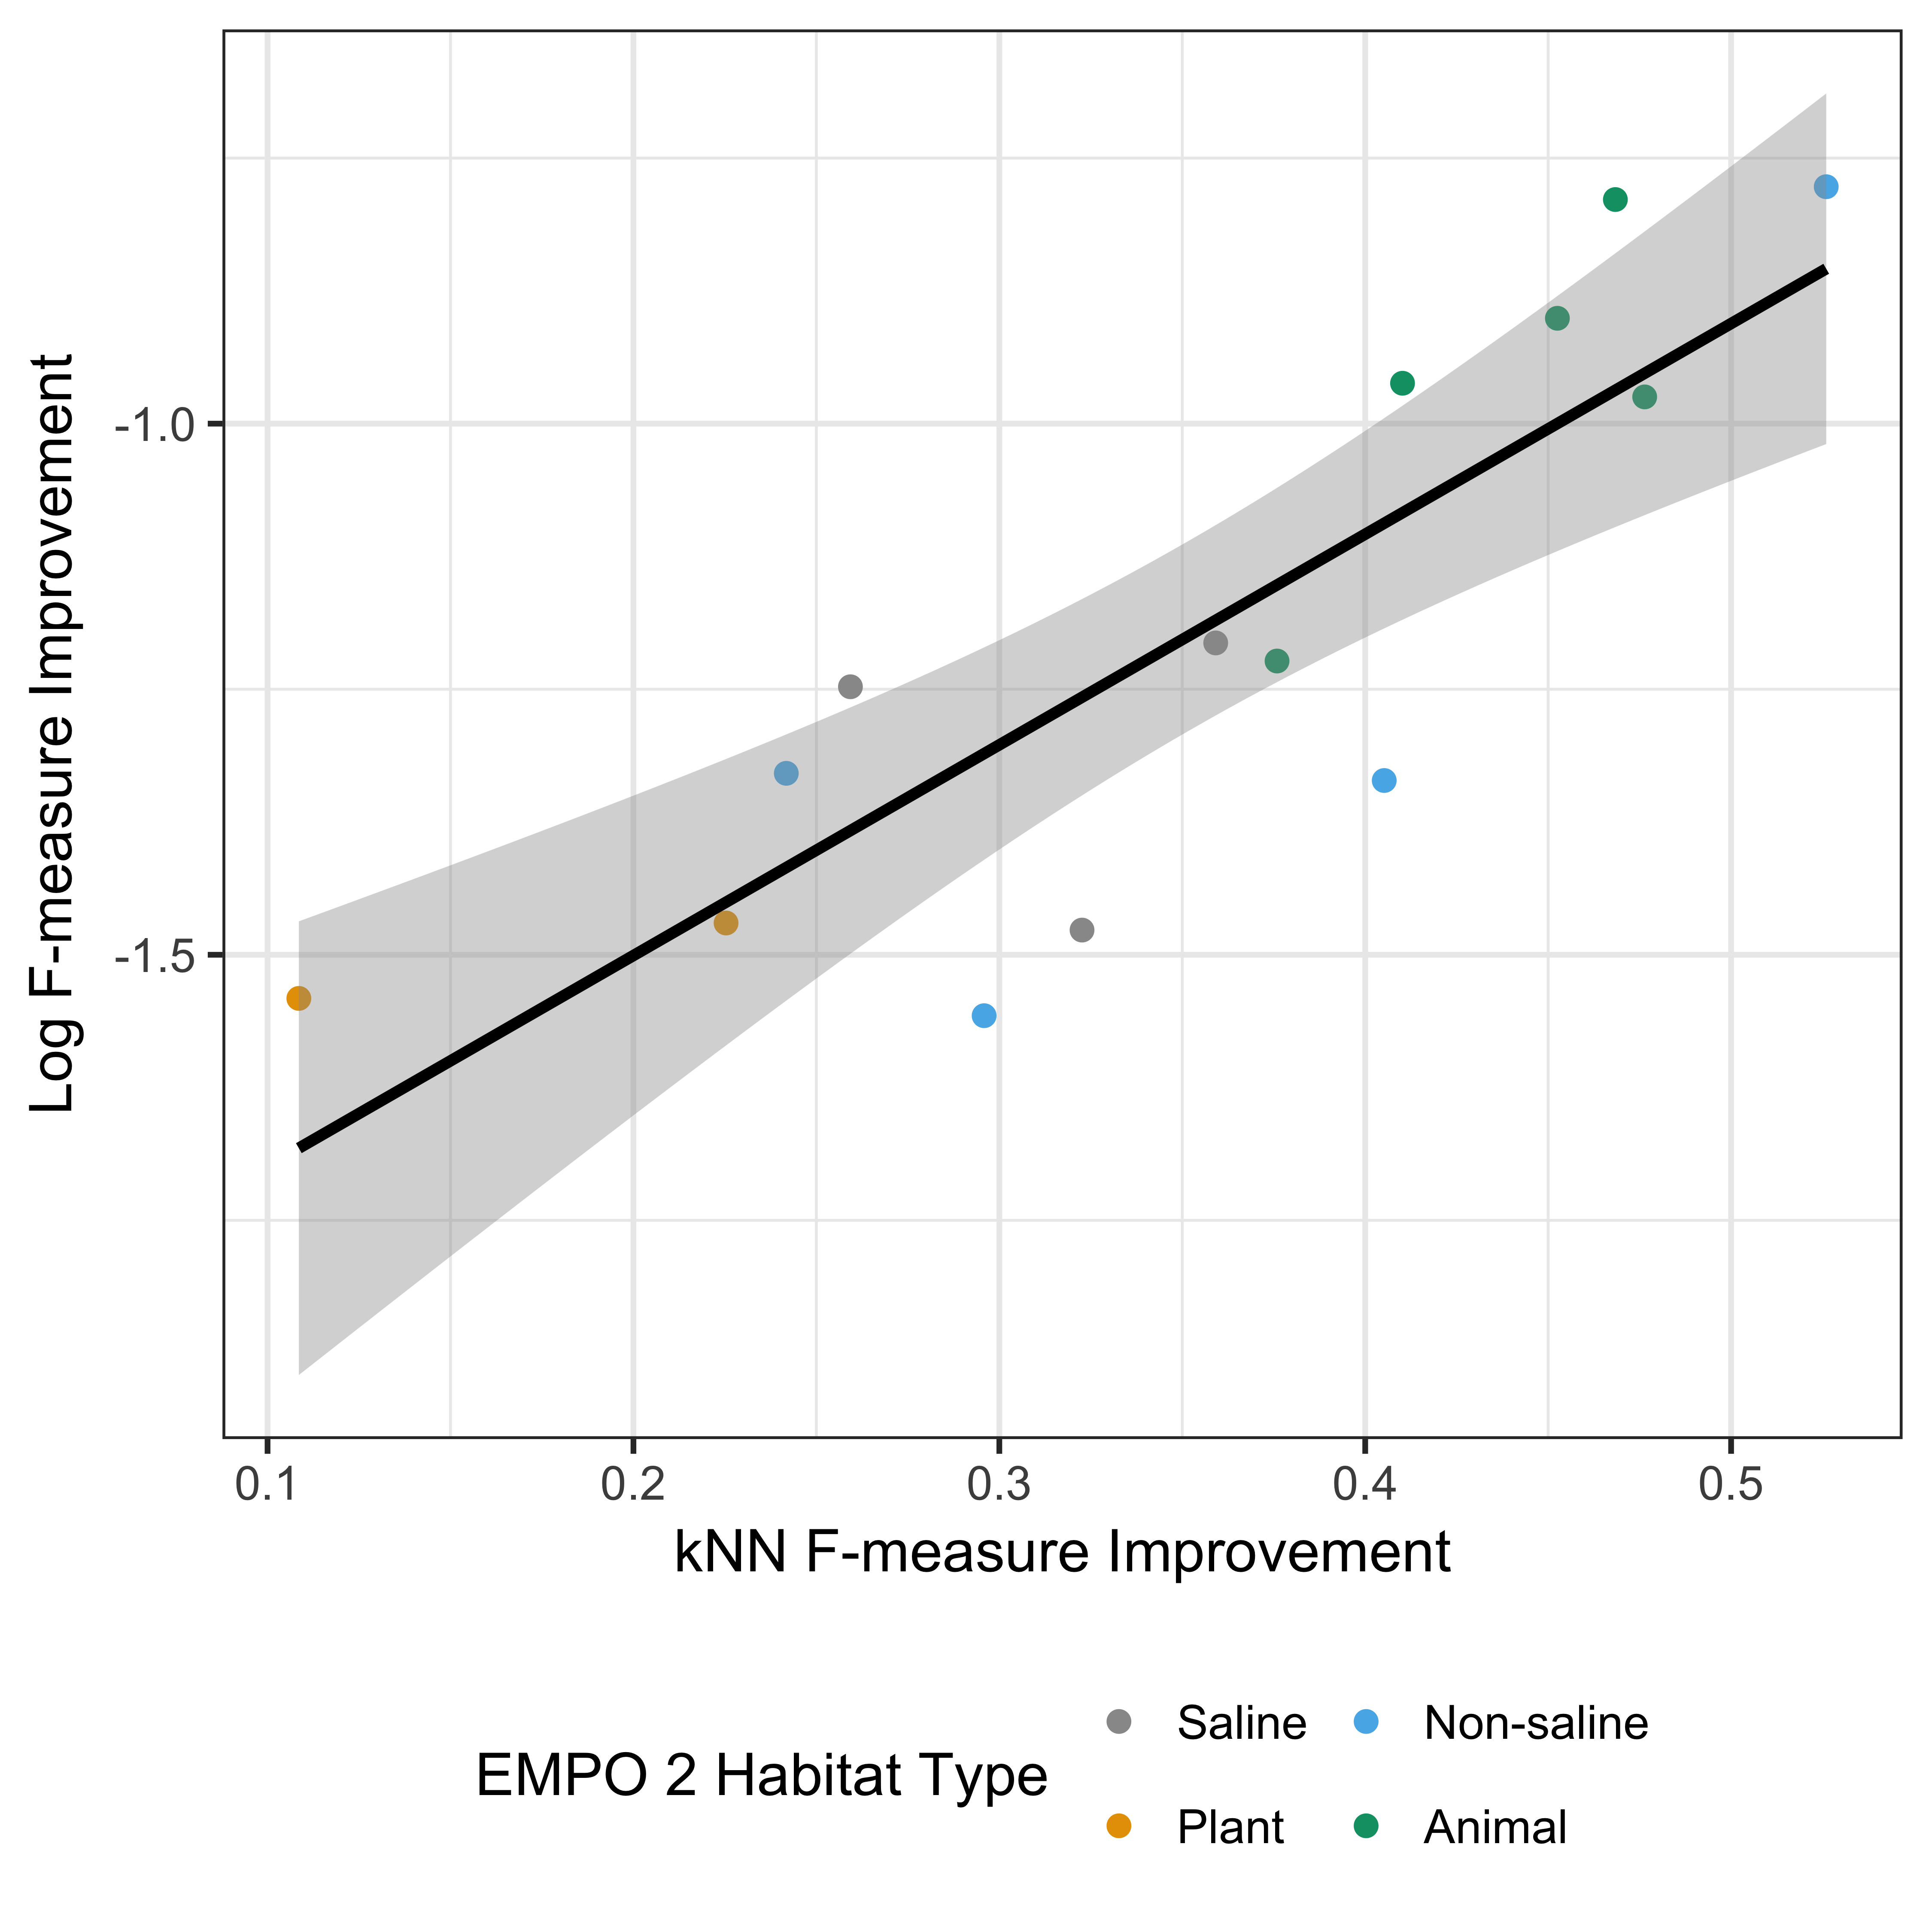

In [12]:
Image('figure6.png')

In [ ]:
VegaLite({
  "mark": "point",
  "encoding": {
    "x": {"type": "quantitative", "field": "ben index"},
    "y": {"type": "quantitative", "field": "improvement", "axis": {"title": "f-measure improvement"}},
    "tooltip": [
        {"type": "ordinal", "field": "type"}
    ]
  }
}, hope)

In [ ]:
weights = Artifact.load(join(empo3_dir, 'animal-proximal-gut', 'results', 'weights.qza'))
weights = weights.view(DataFrame).T['Weight'].to_dict()
Counter(weights).most_common()

In [ ]:
wtf = loocv(y_resampled, indices)

In [ ]:
f1_score?